In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
from sklearn.metrics import mean_squared_error
import re
from matplotlib.dates import DateFormatter
import warnings
warnings.filterwarnings('ignore')

In [18]:
df = pd.read_csv("Interval_Data.csv")
df_extracted = df
df_extracted.head()

,Date,Interval_Price,midpoint
0,7/1/2022,"[135.660004, 139.039993]",137.349998
1,7/5/2022,"[136.929993, 141.610001]",139.269997
2,7/6/2022,"[141.080002, 144.119995]",142.599998
3,7/7/2022,"[143.279999, 146.550003]",144.915001
4,7/8/2022,"[145.0, 147.550003]",146.275002


In [20]:
def str_to_interval(interval_str):
    if not isinstance(interval_str, str):
        return interval_str
    numbers = re.findall(r"[-+]?\d*\.\d+|\d+", interval_str)
    if len(numbers) == 2:
        return pd.Interval(float(numbers[0]), float(numbers[1]))
    return None

df_extracted['Interval_Price'] = df_extracted['Interval_Price'].apply(str_to_interval)
# Remove '[]' and split the interval range into two columns 'Low' and 'High'
# df_extracted[['Low', 'High']] = df_extracted['Interval_Price'].str.strip('[]').str.split('-', expand=True)

# df_extracted['Low'] = df_extracted['Interval_Price'].apply(lambda x: x.left)
# df_extracted['High'] = df_extracted['Interval_Price'].apply(lambda x: x.right)
# df_extracted['Mid'] = df_extracted['Interval_Price'].apply(lambda x: (x.left + x.right) / 2)

df_extracted['Low'] = df_extracted['Interval_Price'].apply(lambda x: x.left if isinstance(x, pd.Interval) else None)
df_extracted['High'] = df_extracted['Interval_Price'].apply(lambda x: x.right if isinstance(x, pd.Interval) else None)
df_extracted['Mid'] = df_extracted['Interval_Price'].apply(lambda x: (x.left + x.right) / 2 if isinstance(x, pd.Interval) else None)



# Convert 'Low' and 'High' to numeric, and calculate the 'Mid' from 'Low' and 'High'.
# df_extracted['Low'] = pd.to_numeric(df_extracted['Low'])
# df_extracted['High'] = pd.to_numeric(df_extracted['High'])
# df_extracted['Mid'] = pd.to_numeric(df_extracted['midpoint'])

df_extracted = df_extracted.drop(columns=['Interval_Price','midpoint'])
df_extracted.head()

,Date,Low,High,Mid
0,7/1/2022,135.660004,139.039993,137.349998
1,7/5/2022,136.929993,141.610001,139.269997
2,7/6/2022,141.080002,144.119995,142.599998
3,7/7/2022,143.279999,146.550003,144.915001
4,7/8/2022,145.000000,147.550003,146.275002


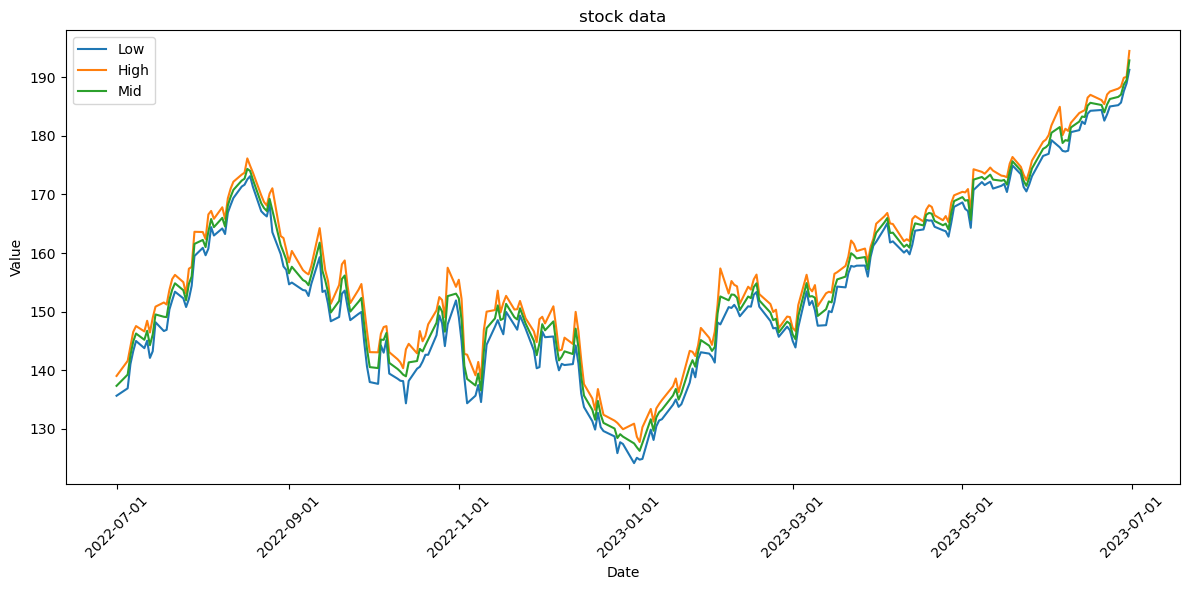

In [21]:
df_value = df_extracted
df_value = pd.DataFrame(df_value)
df_value['Date'] = pd.to_datetime(df_value['Date'])  # Convert the 'Date' column to datetime format
df_value.set_index('Date', inplace=True)

plt.figure(figsize=(12, 6))
for column in df_value.columns:
    plt.plot(df_value.index, df_value[column], label=column)# Format the x-axis

date_format = DateFormatter("%Y-%m-%d")  # Format as Year-Month-Day
plt.gca().xaxis.set_major_formatter(date_format)
plt.xticks(rotation=45)  # Rotate date labels for clarity

plt.title('stock data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
plt.show()

In [22]:
df = df_extracted
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
print(df.dtypes)

Low     float64
High    float64
Mid     float64
dtype: object


# Determine p,d,q value

### ADF test

The ADF test uses an autoregressive model and optimizes an information criterion across multiple different lag values. The p-value resulting from the ADF test is used to reject or accept the null hypothesis.

If the p-value is less than the significance level (typically 0.05), we reject the null hypothesis and infer that the time series is indeed stationary. If the p-value is greater than the significance level, we fail to reject the null hypothesis and infer that the time series is not stationary.

In [23]:
from statsmodels.tsa.stattools import adfuller

# Iterate over the columns of df_extracted, starting from the second column
for column_name in df_extracted.columns:
    print(f"Performing ADF test for: {column_name} price")
    adf_result = adfuller(df_extracted[column_name])
    print(f"ADF Statistic for {column_name}: {adf_result[0]} price")
    print(f"p-value for {column_name}: {adf_result[1]}")
    print()

Performing ADF test for: Low price
ADF Statistic for Low: nan price
p-value for Low: nan

Performing ADF test for: High price
ADF Statistic for High: nan price
p-value for High: nan

Performing ADF test for: Mid price
ADF Statistic for Mid: nan price
p-value for Mid: nan



From the results of the Augmented Dickey-Fuller test, the ADF statistics are -0.48, -0.47 and -0.43. And the P-value is 0.90, which is much larger than 0.05. As a result, we cannot refute the null hypothesis, which suggests that the time series corresponding to these prices exhibit non-stationarity.

### Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF)

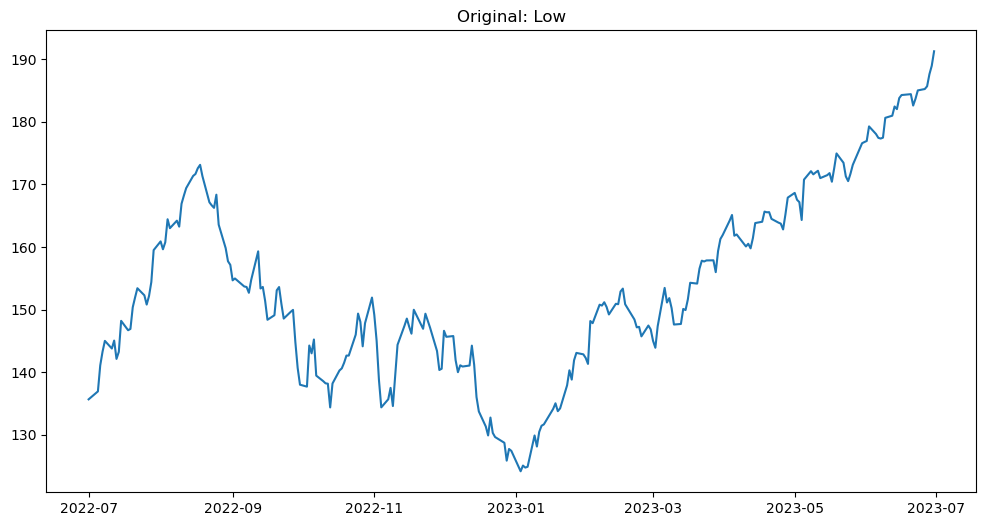

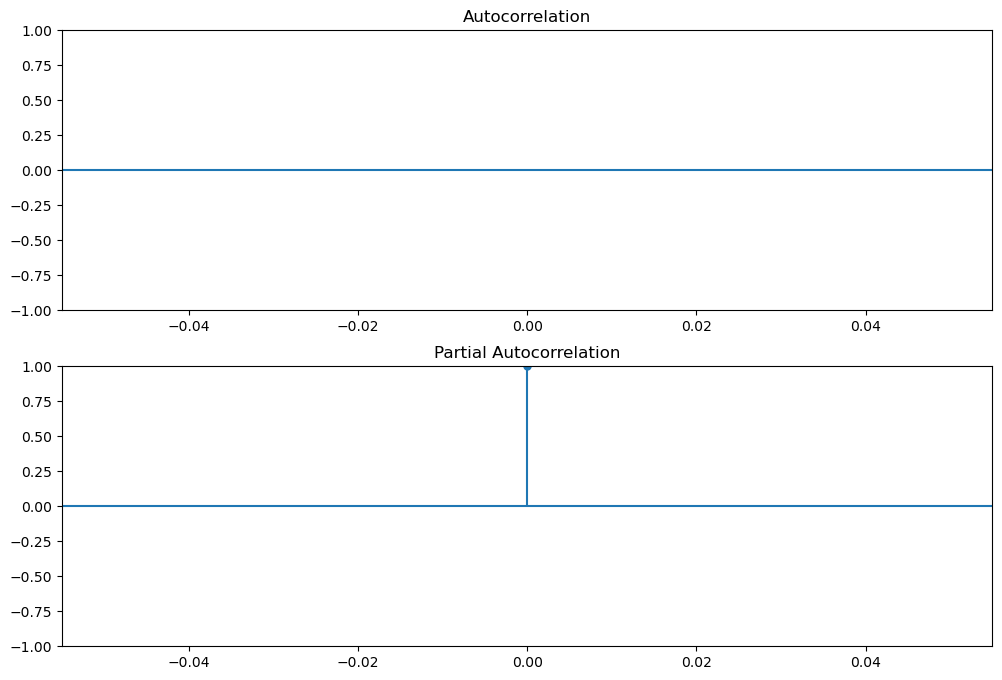

In [7]:
fig, ax1 = plt.subplots( figsize = (12,6))
ax1.plot(df_extracted['Low'].dropna())
ax1.set_title(f"Original: Low")
low_price = df['Low']

# Plot the price
fig, ax = plt.subplots(2, figsize=(12,8))
ax[0] = plot_acf(low_price, ax=ax[0])
ax[1] = plot_pacf(low_price, ax=ax[1])
plt.show()

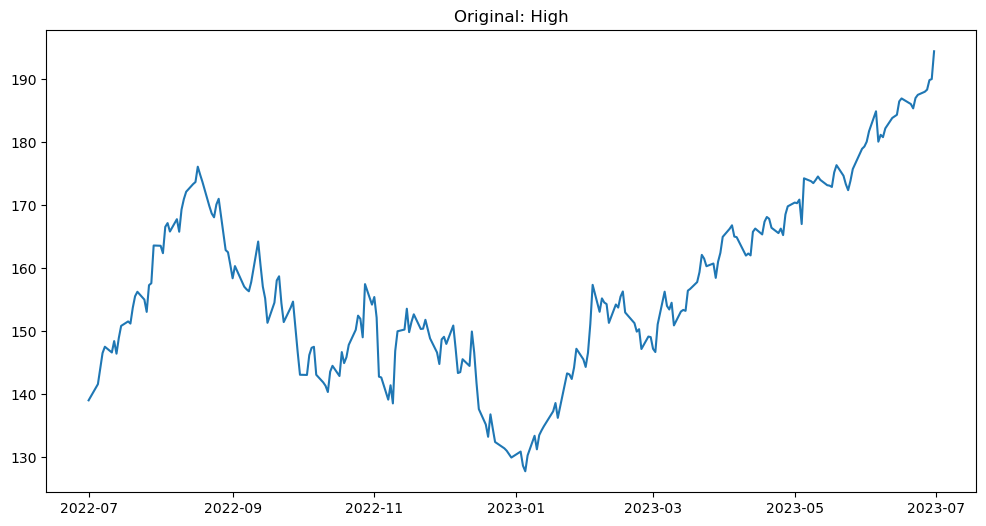

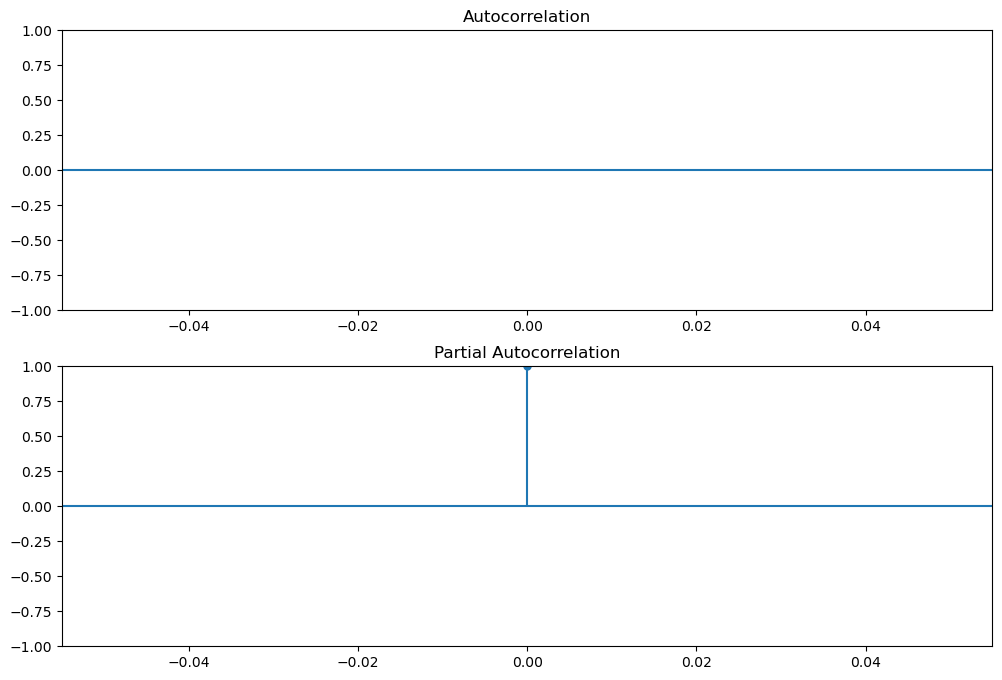

In [8]:
fig, ax1 = plt.subplots( figsize = (12,6))
ax1.plot(df_extracted['High'].dropna())
ax1.set_title(f"Original: High")
High_price = df['High']

# Plot the price
fig, ax = plt.subplots(2, figsize=(12,8))
ax[0] = plot_acf(High_price, ax=ax[0])
ax[1] = plot_pacf(High_price, ax=ax[1])
plt.show()

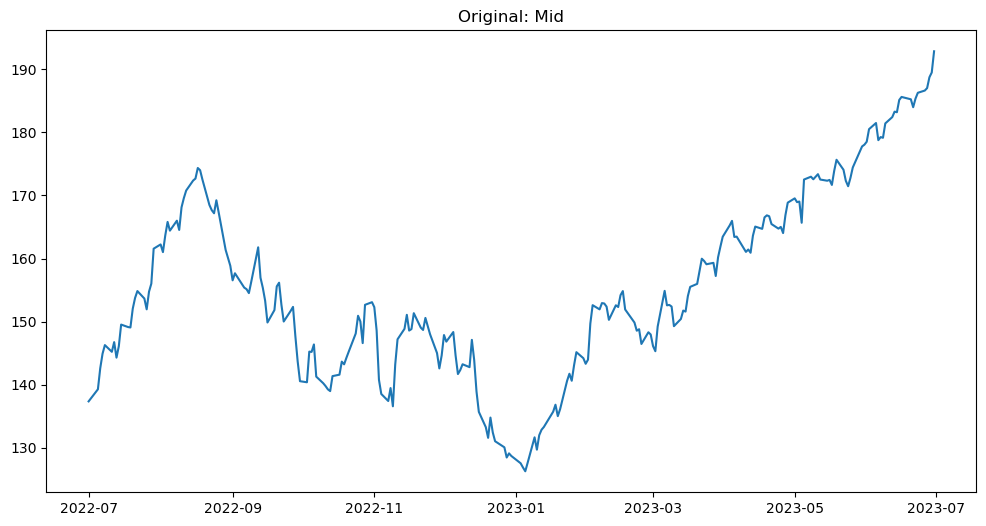

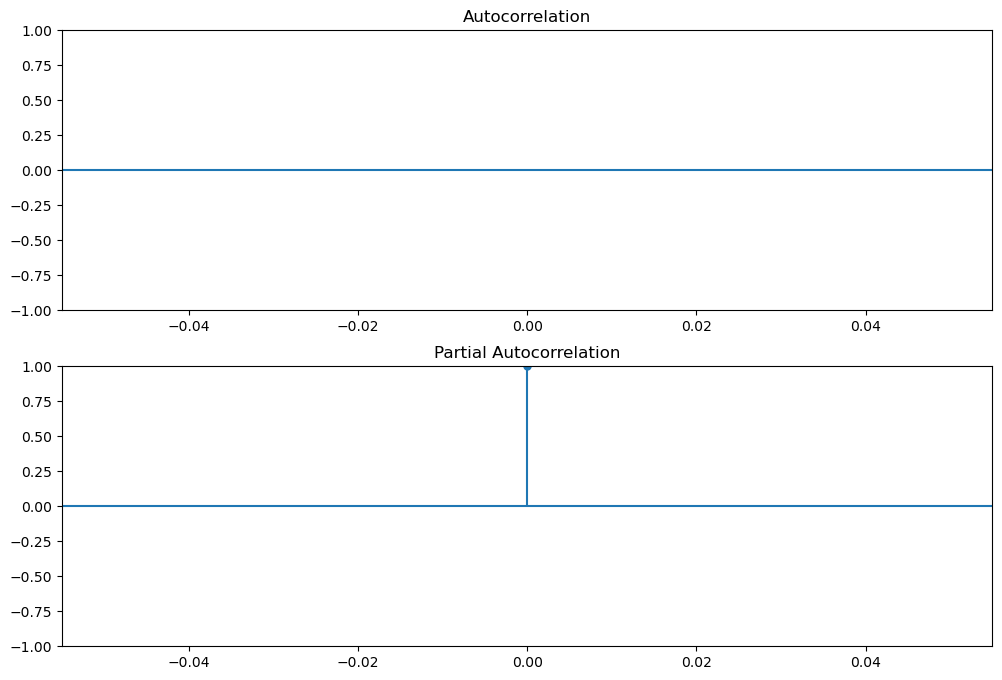

In [9]:
fig, ax1 = plt.subplots( figsize = (12,6))
ax1.plot(df_extracted['Mid'].dropna())
ax1.set_title(f"Original: Mid")
Mid_price = df['Mid']

# Plot the price
fig, ax = plt.subplots(2, figsize=(12,8))
ax[0] = plot_acf(Mid_price, ax=ax[0])
ax[1] = plot_pacf(Mid_price, ax=ax[1])
plt.show()

At the same time, I can also see from the graphs of auto-correlation function (ACF) and partial auto-correlation function (PACF) that the auto-correlation and partial auto-correlation of data are gradually decaying, which is also a feature of non-stationary sequences.

Therefore, I need to make a first-order difference on the data to make it smooth before applying the ARIMA model.

### Selecting d

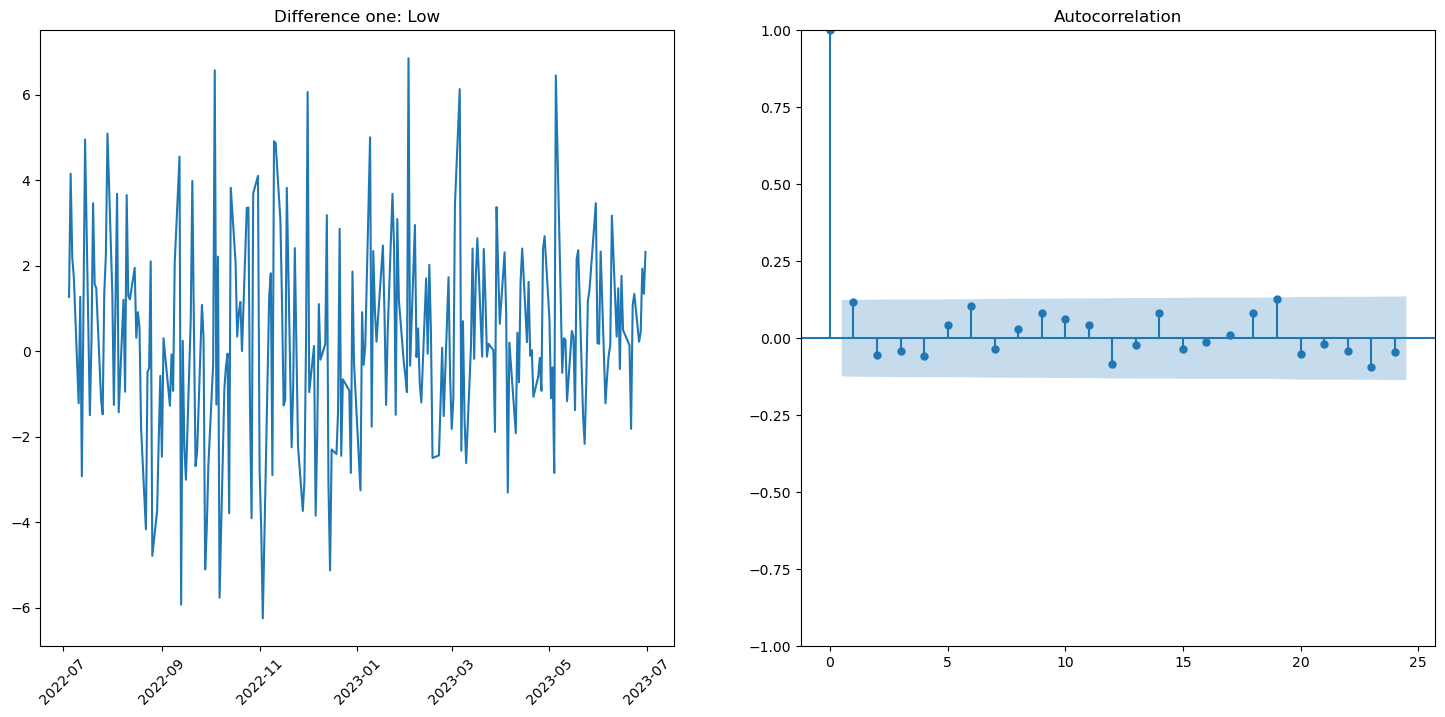

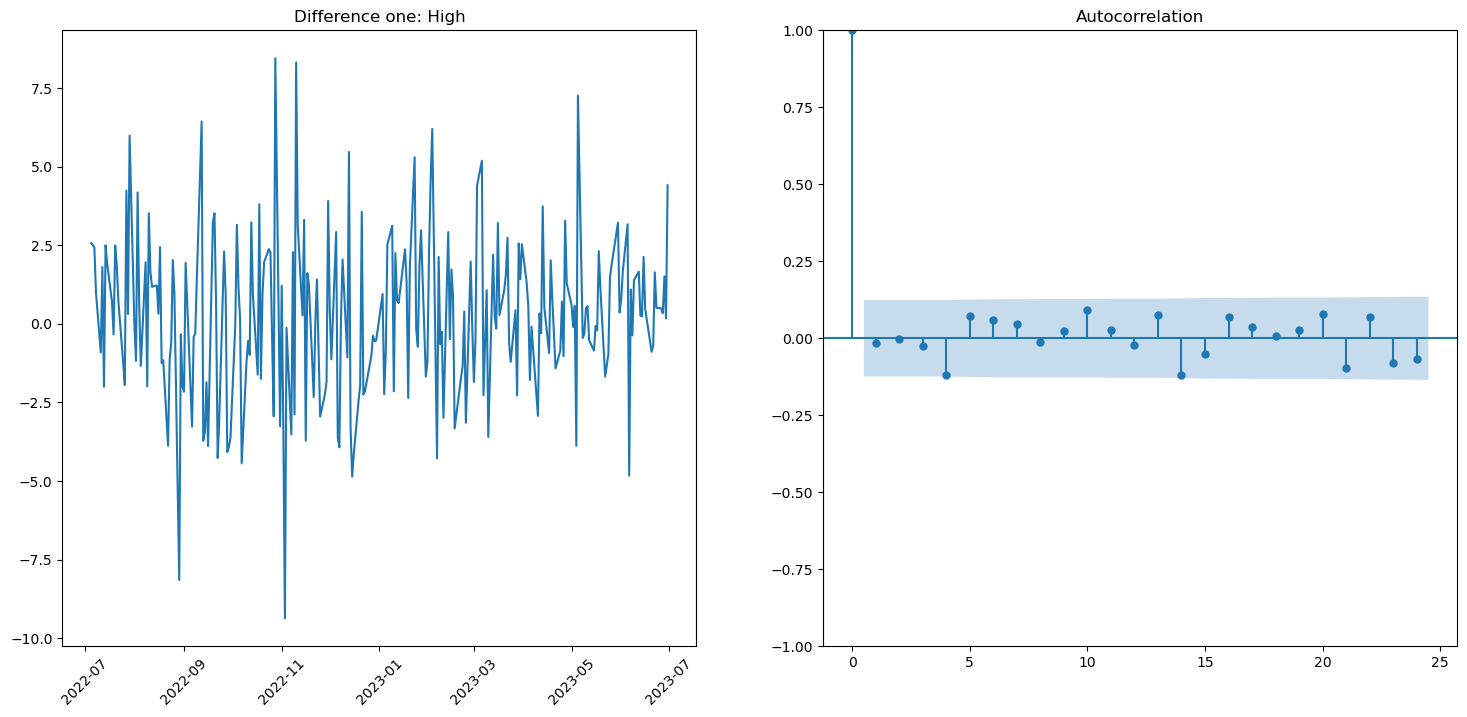

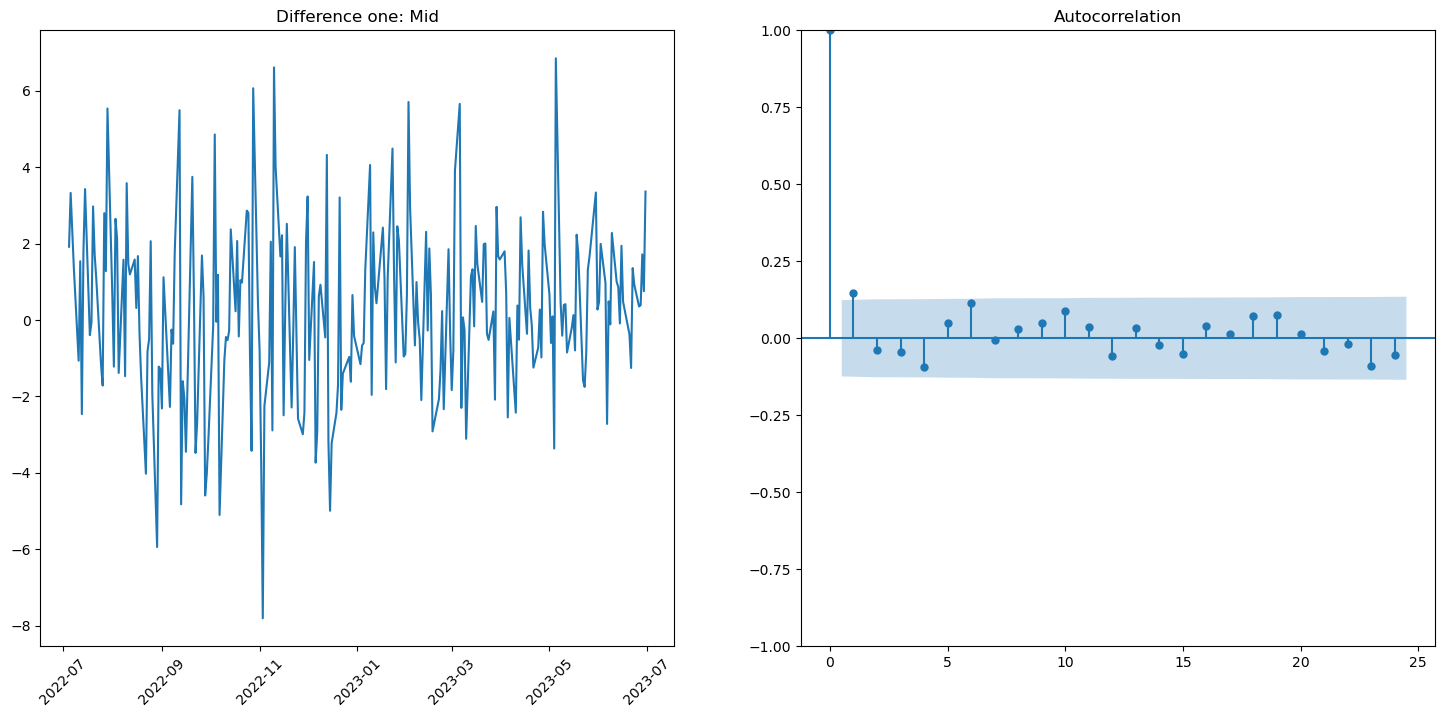

In [10]:
for price_name in df_extracted.columns[0:]:

    diff = df_extracted[price_name].diff().dropna()
    fig, (axis1, axis2) = plt.subplots( 1, 2, figsize=(18,8))
    plt.setp(axis1.get_xticklabels(), rotation=45)
    axis1.plot(diff)
    axis1.set_title(f"Difference one: {price_name}")
    plot_acf(diff, ax=axis2)

In [11]:
# Perform first order differencing
data_diff = df_extracted['Low'].diff().dropna()
# Perform the ADF test on the differenced data
result_diff = adfuller(data_diff)
result_diff[0], result_diff[1]

(-13.957380634004428, 4.5852640620525725e-26)

The ADF test result after first-order difference is as follows: the test statistic is -13.96, and the p-value is close to 0. Because the P-value is less than 0.05, we can reject the null hypothesis (the data is non-stationary) and accept the alternative hypothesis (the data is stationary). So, we can move on to fitting the ARIMA model.

In [12]:
# Perform first order differencing
data_diff = df_extracted['High'].diff().dropna()
# Perform the ADF test on the differenced data
result_diff = adfuller(data_diff)
result_diff[0], result_diff[1]

(-15.91139214549477, 8.115949910619213e-29)

The ADF test result after first-order difference is as follows: the test statistic is -15.91, and the p-value is close to 0. Because the P-value is less than 0.05, we can reject the null hypothesis (the data is non-stationary) and accept the alternative hypothesis (the data is stationary). So, we can move on to fitting the ARIMA model.

In [13]:
# Perform first order differencing
data_diff = df_extracted['Mid'].diff().dropna()
# Perform the ADF test on the differenced data
result_diff = adfuller(data_diff)
result_diff[0], result_diff[1]

(-13.515021083272433, 2.805272538598129e-25)

The ADF test result after first-order difference is as follows: the test statistic is -13.52, and the p-value is close to 0. Because the P-value is less than 0.05, we can reject the null hypothesis (the data is non-stationary) and accept the alternative hypothesis (the data is stationary). So, we can move on to fitting the ARIMA model.

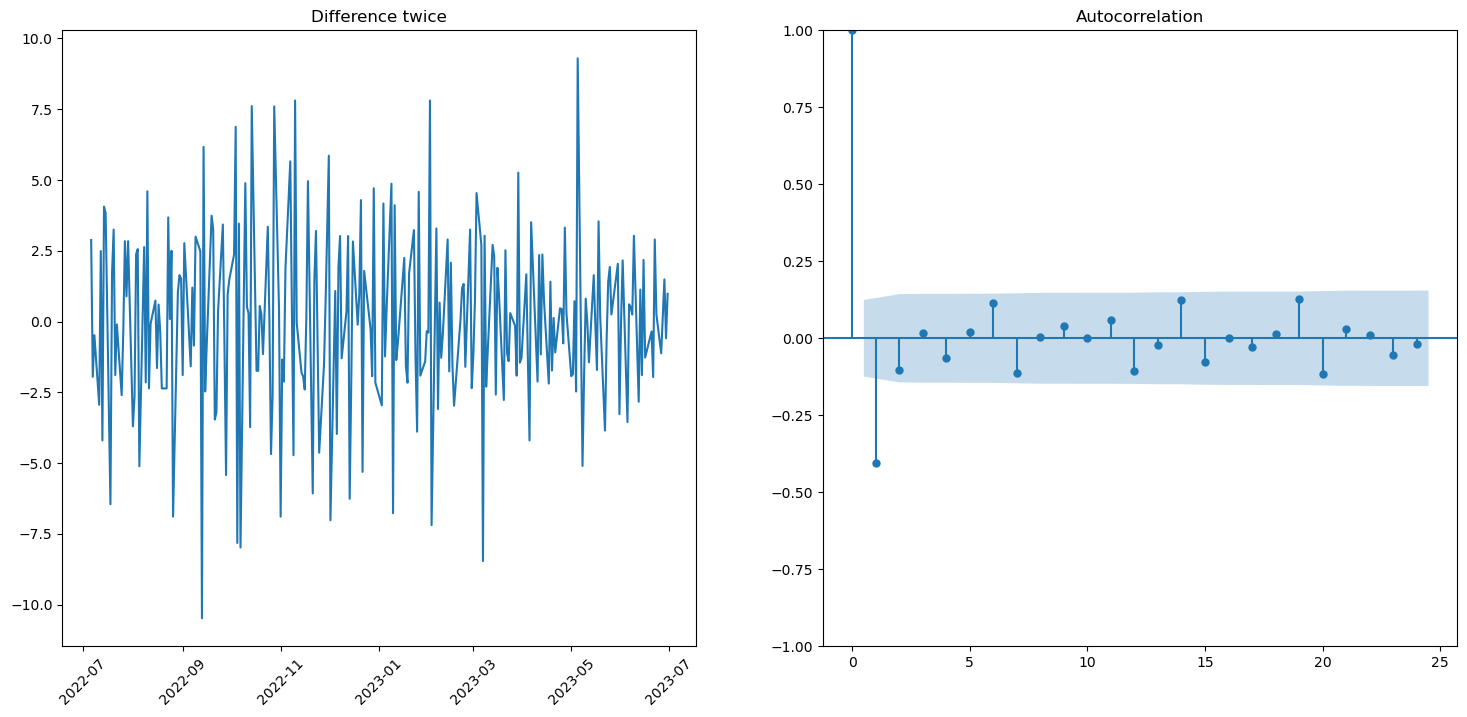

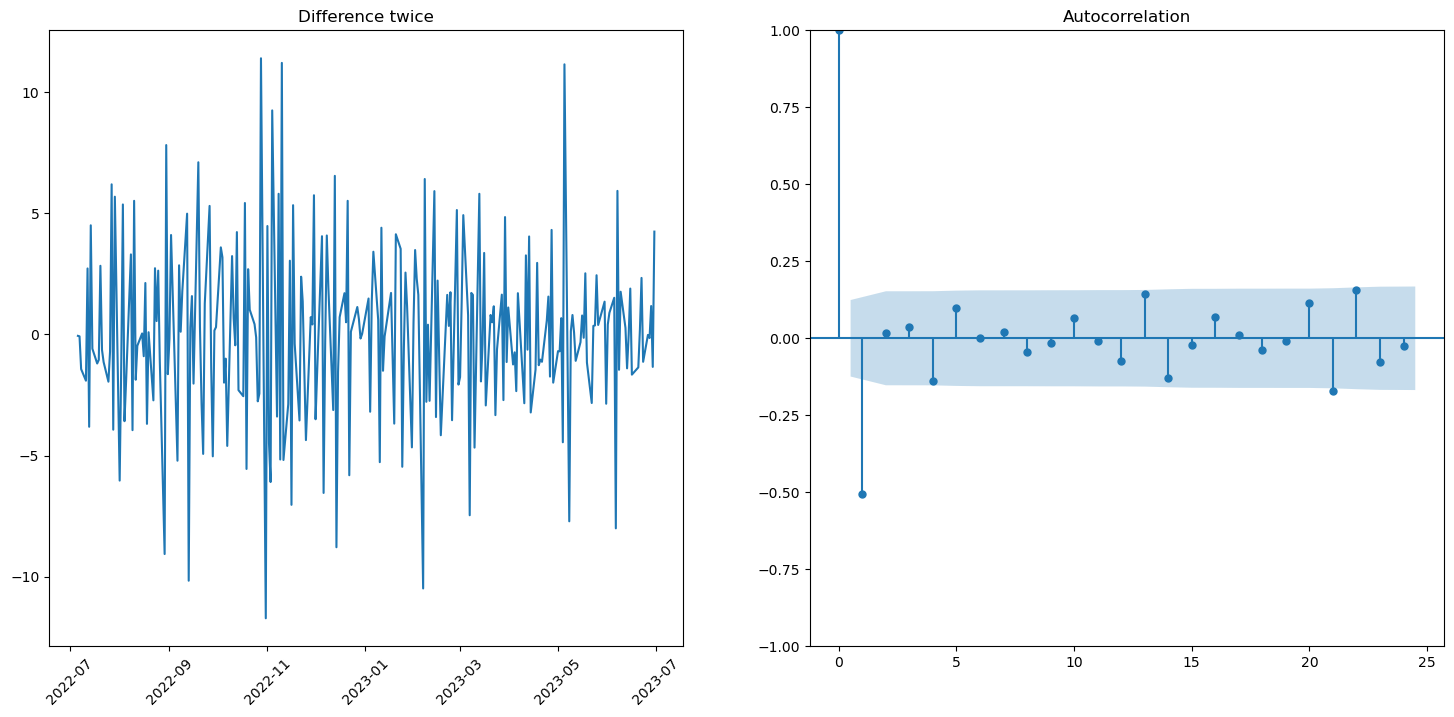

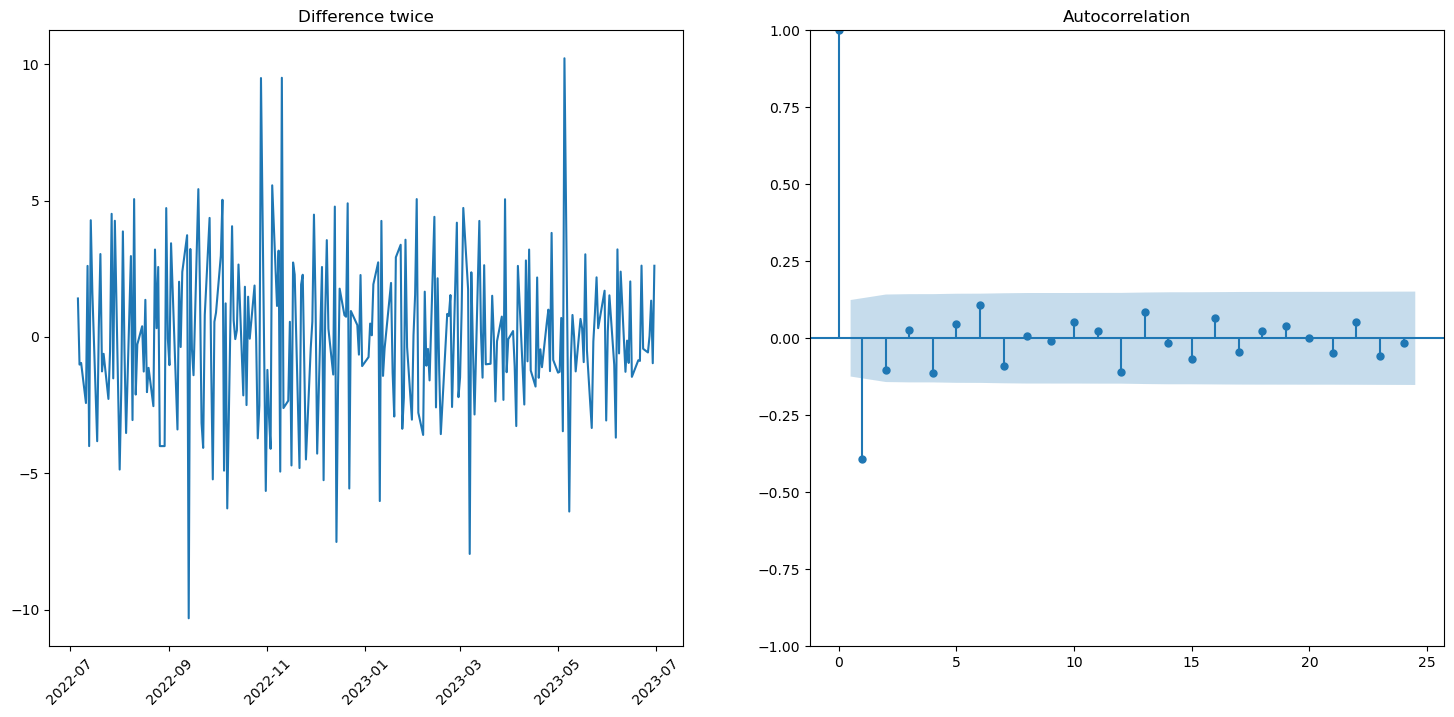

In [14]:
for price_name in df_extracted.columns[0:]:

    diff = df_extracted[price_name].diff().diff().dropna()
    fig, (axis1, axis2) = plt.subplots( 1, 2, figsize=(18,8))
    plt.setp(axis1.get_xticklabels(), rotation=45)
    axis1.plot(diff)
#     axis1.set_title(f"Difference twice: {price_name}")
    axis1.set_title(f"Difference twice")
    plot_acf(diff, ax=axis2);

The auto-correlation observed in both "Difference one" and "Difference twice" shows minimal variance. Therefore, for all price, we should set the differencing value to 1.

The pmdarima package can also be utilized to determine the degree of differencing. The following code show an example:

In [15]:
from pmdarima.arima.utils import ndiffs
n1 = ndiffs(df_extracted.Low, test="adf")
n2 = ndiffs(df_extracted.High, test="adf")
n3 = ndiffs(df_extracted.Mid, test="adf")

print(f"The best differencing value for Low price is:", n1)
print(f"The best differencing value for High price is:", n2)
print(f"The best differencing value for Mid price is:", n3)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

As a result, I set d=1 for Low price, high price and Mid price.

### Selecting p

p is the order of the Auto Regressive (AR) term. It corresponds to the number of lags to be used as predictors. The necessary count of AR components can be ascertained by examining the Partial Auto-correlation (PACF) plot. Partial auto-correlation signifies the correlation between the time series and its lags.

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf

# Compute the first differences of the Low prices
first_diff = df_extracted['Low'].diff().dropna()
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(18, 8))
axis1.plot(first_diff)
axis1.set_title("Difference once")
axis2.set_ylim(0, 1)

# plot the partial auto-correlation of the first differences
plot_pacf(first_diff, ax=axis2, method='ywm')
plt.show()

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf

# Compute the first differences of the High prices
first_diff = df_extracted['High'].diff().dropna()
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(18, 9))
axis1.plot(first_diff)
axis1.set_title("Difference once")
axis2.set_ylim(0, 1)

# plot the partial auto-correlation of the first differences
plot_pacf(first_diff, ax=axis2, method='ywm')
plt.show()

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf

# Compute the first differences of the Mid prices
first_diff = df_extracted['Mid'].diff().dropna()
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(18, 9))
axis1.plot(first_diff)
axis1.set_title("Difference once")
axis2.set_ylim(0, 1)

# plot the partial auto-correlation of the first differences
plot_pacf(first_diff, ax=axis2, method='ywm')
plt.show()

From the PACF plot above, it looks like the PACF crosses the upper confidence interval for the first time at lag 1. Therefore, it might start by considering p=1 for three ARIMA models.

### Selecting q

'q' is the order of the Moving Average (MA) term. It signifies the number of lagged forecast errors that should be incorporated into the ARIMA model. The number of MA terms can be determined by inspecting the Auto-correlation Function (ACF) plot.

In [ ]:
# Calculate the first differences of the 'Low' column
diff_low = df_extracted['Low'].diff().dropna()
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(18, 8))
axis1.plot(diff_low)
axis1.set_title("First Difference")
axis2.set_ylim(0, 1)
plot_acf(diff_low, ax=axis2)
plt.show()

In [ ]:
# Calculate the first differences of the 'High' column
diff_low = df_extracted['High'].diff().dropna()
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(18, 8))
axis1.plot(diff_low)
axis1.set_title("First Difference")
axis2.set_ylim(0, 1)
plot_acf(diff_low, ax=axis2)
plt.show()

In [ ]:
# Calculate the first differences of the 'Mid' column
diff_low = df_extracted['Mid'].diff().dropna()
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(18, 8))
axis1.plot(diff_low)
axis1.set_title("First Difference")
axis2.set_ylim(0, 1)
plot_acf(diff_low, ax=axis2)
plt.show()

Looking at the ACF plot, I typically consider the point where the ACF plot crosses the upper confidence interval for the first time as the q value for the ARIMA model. It is the lag after which the correlation is no longer significant.

From the ACF plot above, it looks like the ACF crosses the upper confidence interval for the first time at lag 1. Therefore, it might start by considering q=1 for my ARIMA model.

In [ ]:
# Fit the ARIMA model with the optimal parameters
model = ARIMA(df_extracted['Low'], order=[1,1,1])
model_Low_price_fit = model.fit()
model_Low_price_fit.summary()

In [ ]:
# Fit the ARIMA model with the optimal parameters
model = ARIMA(df_extracted['High'], order=[1,1,1])
model_High_price_fit = model.fit()
model_High_price_fit.summary()

In [ ]:
# Fit the ARIMA model with the optimal parameters
model = ARIMA(df_extracted['Mid'], order=[1,1,1])
model_Mid_price_fit = model.fit()
model_Mid_price_fit.summary()

### Plot residual errors

In [ ]:
residuals = model_Low_price_fit.resid

# Plot residuals
plt.figure(figsize=(10,6))
plt.plot(residuals)
plt.title('Residuals from ARIMA Model')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.show()

This is the residual plot from the ARIMA model. As you can see from the graph, the residuals fluctuate roughly up and down around the 0 line, with no obvious pattern. This indicates that the model has captured the main information in the data, and there are no remaining trends or periodicity in the residuals. This is a characteristic of a good model.

In [ ]:
from scipy.stats import norm
# Plot histogram of residuals
plt.figure(figsize=(10,6))
plt.hist(residuals, bins=30, density=True, alpha=0.6, color='g')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, residuals.mean(), residuals.std())
plt.plot(x, p, 'k', linewidth=2)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

This is the histogram of the ARIMA model residuals, with the black line representing the probability density function of the normal distribution. As can be seen from the figure, the distribution of residuals is roughly symmetric and close to a normal distribution. This is a characteristic of a good model because, ideally, we want the model's residuals to be random and follow a normal distribution.

In [ ]:
df_extracted.head()
data = pd.DataFrame(df_extracted[['Low']])
data.head()

In [ ]:
# data = pd.DataFrame(df_extracted[['Low']])
# # data['Date'] = pd.to_datetime(data['Date'])
# # data.set_index('Date', inplace=True)
#
# # Divide the data into training sets and test sets
# train_size = int(len(data) * 0.8)
# train, test = data[:train_size], data[train_size:]
#
# start_date = pd.to_datetime(test.index.min())
# end_date = pd.to_datetime(test.index.max())
#
# # Use the best parameters to train the model
# model = ARIMA(train, order=(1,1,1))
# model_fit = model.fit()
# forecast = model_fit.forecast(len(test))
# # forecast = model_fit.predict('20220630','20230630', dynamic = True, typ = 'levels')
# forecast_series = pd.Series(forecast.values, index=test.index) # Updated this line
#
# # Draw a line chart of forecast results
# fig, ax = plt.subplots(figsize=(10, 6))
# ax.plot(train, label='Training Data')
# ax.plot(test, label='Test Data')
# ax.plot(forecast_series, label='Predicted Data', linestyle='--')
# ax.legend()
# ax.set_title("ARIMA Model Prediction")
# ax.set_xlabel("Date")
# ax.set_ylabel("Low Price")
# plt.show()

In [ ]:
data = pd.DataFrame(df_extracted[['Low']])
# data['Date'] = pd.to_datetime(data['Date'])
# data.set_index('Date', inplace=True)

# Divide the data into training sets and test sets
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# Reinitialize lists to store predictions and Reset training data
predictions = []
predicted_dates = []

# Iterate over the test data
for date in test.index:
    # Train ARIMA model
    model = ARIMA(train, order=(1,1,1))
    model_fit = model.fit()

    # Forecast the next one point
    forecast = model_fit.forecast(steps=1).values
    predictions.append(forecast[0])
    predicted_dates.append(date)
    
    # For the next iteration, append the actual observed value from the test data to the training data
#     train = train.append(test.loc[date])
    train.loc[date] = test.loc[date]

forecast_series_Low = pd.Series(predictions, index=predicted_dates)
forecast_series_Low.name = "Low_forecast"
print(forecast_series_Low.head())

In [ ]:
mse = mean_squared_error(test, forecast_series_Low)
print(f'MSE of Low price forecast: {mse}')

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(train, label='Training Data')
ax.plot(test, label='Test Data')
ax.plot(forecast_series_Low, label='Iterative Predicted Data', linestyle='--')
ax.legend()
ax.set_title("ARIMA Model Iterative Prediction")
ax.set_xlabel("Date")
ax.set_ylabel("Low Price")
plt.show()

In [ ]:
data = pd.DataFrame(df_extracted[['High']])
# data['Date'] = pd.to_datetime(data['Date'])
# data.set_index('Date', inplace=True)

# Divide the data into training sets and test sets
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# Reinitialize lists to store predictions and Reset training data
predictions = []
predicted_dates = []

# Iterate over the test data
for date in test.index:
    model = ARIMA(train, order=(1,1,1))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=1).values
    predictions.append(forecast[0])
    predicted_dates.append(date)
#     train = train.append(test.loc[date])
    train.loc[date] = test.loc[date]

forecast_series_High = pd.Series(predictions, index=predicted_dates)
forecast_series_High.name = "High_forecast"
print(forecast_series_High.head())

In [ ]:
mse = mean_squared_error(test, forecast_series_High)
print(f'MSE of High price forecast: {mse}')

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(train, label='Training Data')
ax.plot(test, label='Test Data')
ax.plot(forecast_series_High, label='Iterative Predicted Data', linestyle='--')
ax.legend()
ax.set_title("ARIMA Model Iterative Prediction")
ax.set_xlabel("Date")
ax.set_ylabel("High Price")
plt.show()

In [ ]:
data = pd.DataFrame(df_extracted[['Mid']])
# data['Date'] = pd.to_datetime(data['Date'])
# data.set_index('Date', inplace=True)

train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]
predictions = []
predicted_dates = []
train, test = data[:train_size], data[train_size:]

for date in test.index:
    model = ARIMA(train, order=(1,1,1))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=1).values
    predictions.append(forecast[0])
    predicted_dates.append(date)
#     train = train.append(test.loc[date])
    train.loc[date] = test.loc[date]

forecast_series_Mid = pd.Series(predictions, index=predicted_dates)
forecast_series_Mid.name = "Mid_forcast"
forecast_series_Mid.head()

In [ ]:
mse = mean_squared_error(test, forecast_series_Mid)
print(f'MSE of middle price forecast: {mse}')

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(train, label='Training Data')
ax.plot(test, label='Test Data')
ax.plot(forecast_series_Mid, label='Iterative Predicted Data', linestyle='--')
ax.legend()
ax.set_title("ARIMA Model Iterative Prediction")
ax.set_xlabel("Date")
ax.set_ylabel("Mid Price")
plt.show()

In [ ]:
df_low = forecast_series_Low.to_frame(name="Low_forecast")
df_mid = forecast_series_Mid.to_frame(name="Mid_forecast")
df_high = forecast_series_High.to_frame(name="High_forecast")

merged_df = pd.merge(df_low, df_mid, left_index=True, right_index=True)
interval_df = pd.merge(merged_df, df_high, left_index=True, right_index=True)
interval_df.index.name = 'Date'
interval_df.head()

In [ ]:
plt.figure(figsize=(12, 6))
for column in interval_df.columns:
    plt.plot(interval_df.index, interval_df[column], label=column)

plt.title('Forecasts')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Convert 'Low' and 'High' columns to intervals
interval_df['forecast_Interval'] = interval_df.apply(lambda row: pd.Interval(row['Low_forecast'], row['High_forecast'], closed='both'), axis=1)

data = interval_df[['forecast_Interval']]
df_mid = df_mid.rename(columns={df_mid.columns[0]: 'forecast_midpoint'})
data = data.join(df_mid)

data.to_csv('Forecast_Interval_Data.csv')
data.head()

In [ ]:
df_forecast = pd.read_csv('Forecast_Interval_Data.csv')
df_real = pd.read_csv('Interval_Data.csv')
def trade_strategy(forecast, initial_capital):
    capital = initial_capital
    shares = 0
    buy_price = None
    sell_price = None
    buy_dates = []
    sell_dates = []

    for i in range(len(forecast) - 1):
        current_price = forecast[i]
        next_price = forecast[i + 1]

        if next_price > current_price and shares == 0:
            buy_price = current_price
            shares = capital // buy_price
            capital -= shares * buy_price
            buy_dates.append(forecast.index[i])

        elif next_price < current_price and shares > 0:
            sell_price = current_price
            capital += shares * sell_price
            shares = 0
            sell_dates.append(forecast.index[i])

    if shares > 0:
        capital += shares * forecast[-1]
        sell_dates.append(forecast.index[-1])

    return capital, buy_dates, sell_dates

forecast_price = df_forecast.set_index('Date')['forecast_midpoint']

# Execute the trading strategy based on the forecasted midpoint values
capital_after_trade, buy_dates, sell_dates = trade_strategy(forecast_price, 100000)

# Calculate the actual transaction amounts using the real midpoint data
real_prices = df_real.set_index("Date")["midpoint"]
actual_buy_prices = real_prices.loc[buy_dates]
actual_sell_prices = real_prices.loc[sell_dates]

actual_capital = 100000
actual_shares = 0

for buy_date, sell_date in zip(buy_dates, sell_dates):
    actual_buy_price = actual_buy_prices[buy_date]
    actual_sell_price = actual_sell_prices[sell_date]
    actual_shares = actual_capital // actual_buy_price
    actual_capital -= actual_shares * actual_buy_price
    actual_capital += actual_shares * actual_sell_price
    actual_shares = 0
print(f"Trading according to the trading strategy and using the forecast value, the amount after the trade is ${capital_after_trade}. But when we calculate the amount of the transaction using the actual data, the actual amount after the transaction is ${actual_capital}")
print(f"We buy stocks in these days: {buy_dates}")
print(f"We sell stocks in these days: {sell_dates}")

In [ ]:
# Filter the real_prices
filtered_real_prices = real_prices[real_prices.index.isin(forecast_price.index)]
# Filter buy and sell dates
filtered_buy_dates = [date for date in buy_dates if date in forecast_price.index]
filtered_sell_dates = [date for date in sell_dates if date in forecast_price.index]
filtered_dates = filtered_real_prices.index

plt.figure(figsize=(15,8))
plt.plot(filtered_dates, filtered_real_prices, label="Actual Midpoint", color="blue", alpha=0.6)

# Highlight the buy and sell points
plt.scatter(filtered_buy_dates, filtered_real_prices.loc[filtered_buy_dates], color="green", label="Buy", marker="^", alpha=1)
plt.scatter(filtered_sell_dates, filtered_real_prices.loc[filtered_sell_dates], color="red", label="Sell", marker="v", alpha=1)

# Annotate the buy and sell points
for buy_date in filtered_buy_dates:
    price = filtered_real_prices.loc[buy_date]
    plt.annotate(f"Buy @ {price:.2f}", (buy_date, price), textcoords="offset points", xytext=(0,10), ha='center')
for sell_date in filtered_sell_dates:
    price = filtered_real_prices.loc[sell_date]
    plt.annotate(f"Sell @ {price:.2f}", (sell_date, price), textcoords="offset points", xytext=(0,-15), ha='center')

plt.title("Trading Strategy Based on Forecasted Midpoint (Filtered Dates)")
plt.xlabel("Date")
plt.ylabel("Midpoint Price")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

forecast_data = pd.read_csv("Forecast_Interval_Data.csv")
interval_data = pd.read_csv("Interval_Data.csv")
forecast_data['forecast_low'] = forecast_data['forecast_Interval'].str.extract('\[(.*?),').astype(float)
forecast_data['forecast_high'] = forecast_data['forecast_Interval'].str.extract(', (.*?)\]').astype(float)
interval_data['actual_low'] = interval_data['Interval_Price'].str.extract('\[(.*?),').astype(float)
interval_data['actual_high'] = interval_data['Interval_Price'].str.extract(', (.*?)\]').astype(float)

# Merge data on Date and shift the forcast data
merged_data = pd.merge(forecast_data, interval_data, on='Date', how='left').shift(1)
merged_data['actual_low'] = merged_data['actual_low'].shift(-1)
merged_data['actual_high'] = merged_data['actual_high'].shift(-1)
merged_data['midpoint'] = merged_data['midpoint'].shift(-1)

# buy/sell signals
def generate_signal(row):
    if row['forecast_high'] <= row['actual_low']:
        return 'Sell'
    elif row['forecast_low'] >= row['actual_high']:
        return 'Buy'
    else:
        return 'Hold'

merged_data['Signal'] = merged_data.apply(generate_signal, axis=1)
merged_data[['Date', 'forecast_low', 'forecast_high', 'actual_low', 'actual_high', 'midpoint', 'Signal']].head(10)

In [ ]:
initial_balance = 100000
balance = initial_balance
stock_quantity = 0

# iloc[:-1] is used to avoid NaN in the last row
for _, row in merged_data.iloc[:-1].iterrows():
    if row['Signal'] == 'Buy' and balance > 0:
        stock_quantity = balance / row['midpoint']
        balance = 0
    elif row['Signal'] == 'Sell' and stock_quantity > 0:
        balance = stock_quantity * row['midpoint']
        stock_quantity = 0

# balance + value of stocks held, iloc[-2] means use the last two day of data
final_wealth = balance + stock_quantity * merged_data['midpoint'].iloc[-2]
print(f"when we calculate the amount of the transaction using the price of midpoint. the actual amount after the transaction is ${final_wealth}")

In [ ]:
# initial_balance = 100000
# balance = initial_balance
# stock_quantity = 0
#
# # iloc[:-1] is used to avoid NaN in the last row
# for _, row in merged_data.iloc[:-1].iterrows():
#     if row['Signal'] == 'Buy' and balance > 0:
#         stock_quantity += balance / row['midpoint']
#         balance = 0
#     elif row['Signal'] == 'Sell':
#         # Sell 30% of stocks held or all if stocks held is less than 30%
#         sell_quantity = min(stock_quantity * 0.3, stock_quantity)
#         balance += sell_quantity * row['midpoint']
#         stock_quantity -= sell_quantity
#
# # balance + value of stocks held, iloc[-2] means use the last two day of data
# final_wealth = balance + stock_quantity * merged_data['midpoint'].iloc[-2]
# final_wealth


In [ ]:
# Identify buy and sell dates
buy_dates = merged_data[merged_data['Signal'] == 'Buy']['Date'][1:]
sell_dates = merged_data[merged_data['Signal'] == 'Sell']['Date'][1:]
dates = merged_data['Date'][1:]

plt.figure(figsize=(15, 7))
plt.fill_between(dates, merged_data['forecast_low'][1:], merged_data['forecast_high'][1:], color='blue', alpha=0.5, label='Forecast Interval')
plt.fill_between(dates, merged_data['actual_low'][1:], merged_data['actual_high'][1:], color='red', alpha=0.3, label='Actual Interval')
plt.scatter(buy_dates, merged_data[merged_data['Signal'] == 'Buy']['midpoint'][1:], color='green', marker='^', label='Buy Signal')
plt.scatter(sell_dates, merged_data[merged_data['Signal'] == 'Sell']['midpoint'][1:], color='black', marker='v', label='Sell Signal')

plt.title('Forecast vs Actual Price Intervals with Buy/Sell Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# data = pd.read_csv("AAPL.csv")
    # Split data for training

def train_test_split(data, prediction_size):
    train_size = int(len(data) * (1-prediction_size))
    train = pd.DataFrame(data[0:train_size])
    test = pd.DataFrame(data[train_size:len(data)])
    return train, test

In [ ]:
from pmdarima import auto_arima
# 这里假设数据在 'stock_data.csv' 文件中，我们将其读取为 DataFrame
# 由于你的数据是中文的，可能需要制定encoding为'utf-8'
# data = pd.read_csv('AAPL.csv', encoding='utf-8')
# data = df_extracted


# 将 'Date' 列转换为 datetime 类型，并设为索引
# data['Date'] = pd.to_datetime(data['Date'])
# data.set_index('Date', inplace=True)

data = pd.DataFrame(df_extracted[['Low']])
# data['Date'] = pd.to_datetime(data['Date'])
# data.set_index('Date', inplace=True)

train, test = train_test_split(data['Low'], 0.2)


# 使用 auto_arima 函数找到最优的 ARIMA 模型
# arima_model = auto_arima(train,
#                    start_p=0, start_q=0,
#                    max_p=3, max_q=3, m=12,
#                    start_P=0, seasonal=True,
#                    d=1, D=1, trace=True,
#                    error_action='ignore',
#                    suppress_warnings=True,
#                    stepwise=True)
#
# arima_model.summary()

arima_model = auto_arima(train,start_p=0, d=1, start_q=0,
                                   max_p=3, max_d=3, max_q=3,
                                   start_P=0, D=1, start_Q=0,
                                   max_P=5, max_D=5, max_Q=5,
                                   m=12, seasonal=True,
                                   error_action='warn', trace=True,
                                   suppress_warnings=True, stepwise=True,
                                   random_state=20, n_fits=50)
arima_model.summary()

In [ ]:
import matplotlib.pyplot as plt

# Create a DataFrame for the predicted values
# prediction = pd.DataFrame(arima_model.predict(n_periods = len(test)), index = test.index)
# prediction.columns = ['Close']
# forecast_result = model_fit.forecast(steps=len(test))
# # Create a new series with predictions
# forecast_series = pd.Series(forecast_result.values, index=test.index)
# model_fit = arima_model.fit()
# forecast_result = model_fit.forecast(steps=len(test))
# forecast_series = pd.Series(forecast_result.values, index=test.index)
# print(forecast_series)

# Use the model to make predictions
forecast_result = arima_model.predict(n_periods=len(test))

# Create a series with the predictions
forecast_series = pd.Series(forecast_result.values, index=test.index)

print(forecast_series)

# Plot the results
plt.figure(figsize=(20,10))
plt.plot(train, label="Training")
plt.plot(test, label="Test")
plt.plot(forecast_series, label="Predicted")
plt.title("AAPL Stock Closing Price")
plt.legend(loc='best')
plt.show()
